Set testbed:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 用于进度条，可以删除，如果没有这个库，请参见代码中的comments，把对应的那一条删除

# 10-臂赌博机环境（带随机游走的非平稳环境）
class Bandit:
    def __init__(self, num_arms=10):
        self.num_arms = num_arms
        self.q_star = np.zeros(num_arms)  # 初始时所有 q*(a) 设为 0

    def get_reward(self, action):
        return np.random.normal(self.q_star[action], 1)  # N(q*(a), 1)

    def update_q_star(self):
        """ 每一步后，所有 q*(a) 进行随机游走 """
        self.q_star += np.random.normal(0, 0.01, self.num_arms)

    def optimal_action(self):
        """ 返回当前 q*(a) 最高的拉杆索引 """
        return np.argmax(self.q_star)

# 智能体（ε-greedy 策略，支持两种 Q 估计方法）
class Agent:
    def __init__(self, num_arms=10, epsilon=0.1, alpha=None):
        self.epsilon = epsilon
        self.alpha = alpha  # None 代表样本平均法，固定数值代表 α=0.1
        self.q_estimates = np.zeros(num_arms)  # 估计的 Q 值
        self.action_counts = np.zeros(num_arms)  # 记录每个动作的选择次数

    def select_action(self):
        """ ε-greedy 选择策略 """
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.q_estimates))  # 10% 随机探索
        else:
            return np.argmax(self.q_estimates)  # 90% 选择当前最优动作

    def update(self, action, reward):
        """ 更新 Q 估计值 """
        self.action_counts[action] += 1
        if self.alpha is None:  # 样本平均法
            alpha = 1 / self.action_counts[action]
        else:  # 固定步长 α=0.1
            alpha = self.alpha
        self.q_estimates[action] += alpha * (reward - self.q_estimates[action])


experiments:

In [2]:

def run_experiment(num_steps=10000, num_experiments=2000, epsilon=0.1, alpha=None):
    avg_rewards = np.zeros(num_steps)
    optimal_action_pct = np.zeros(num_steps)

    # for _ in range(num_experiments): 如果不想要进度条，就把下面的for循环改成这一行
    for _ in tqdm(range(num_experiments), desc="Running Experiments"):
        bandit = Bandit()
        agent = Agent(epsilon=epsilon, alpha=alpha)
        optimal_action = bandit.optimal_action()

        for step in range(num_steps):
            action = agent.select_action()
            reward = bandit.get_reward(action)
            agent.update(action, reward)
            bandit.update_q_star()  # q*(a) 进行随机游走

            avg_rewards[step] += reward
            optimal_action_pct[step] += (action == bandit.optimal_action())

    avg_rewards /= num_experiments
    optimal_action_pct = (optimal_action_pct / num_experiments) * 100  # 转换为百分比
    return avg_rewards, optimal_action_pct


test:

In [3]:

# 运行实验，比较两种 Q 估计方法
num_steps = 10000
num_experiments = 2000
epsilon = 0.1

# 1️⃣ 样本平均法
print("Sample Average - Incrementally Computed: ")
rewards_sample_avg, optimal_sample_avg = run_experiment(num_steps, num_experiments, epsilon, alpha=None)

# 2️⃣ 固定步长 α=0.1
print("Constant Step-Size: ")
rewards_const_alpha, optimal_const_alpha = run_experiment(num_steps, num_experiments, epsilon, alpha=0.1)


Sample Average - Incrementally Computed: 


Running Experiments: 100%|██████████| 2000/2000 [03:21<00:00,  9.94it/s]


Constant Step-Size: 


Running Experiments: 100%|██████████| 2000/2000 [03:14<00:00, 10.29it/s]


Plot:

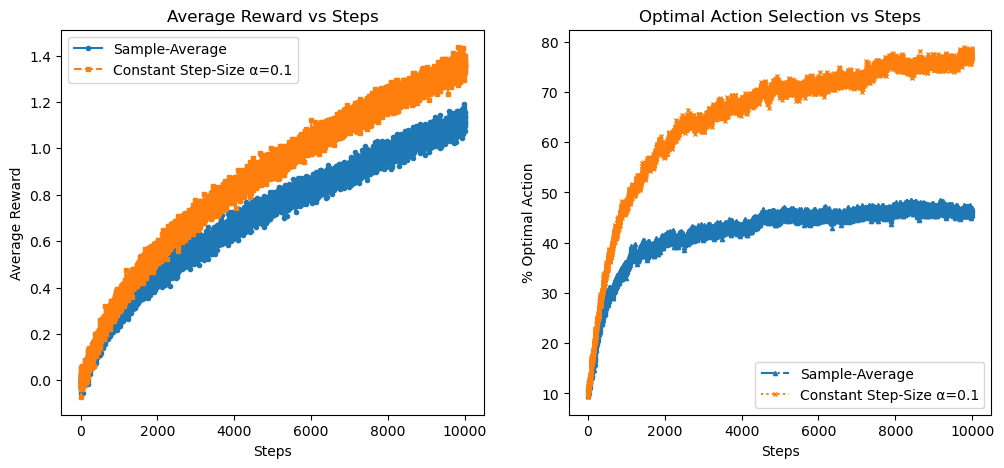

In [4]:

# 绘制结果
plt.figure(figsize=(12, 5))

# 平均奖励曲线
plt.subplot(1, 2, 1)
plt.plot(rewards_sample_avg, linestyle="-", marker="o", markersize=3, linewidth=1.5, label='Sample-Average')
plt.plot(rewards_const_alpha, linestyle="--", marker="s", markersize=3, linewidth=1.5, label='Constant Step-Size α=0.1')
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Average Reward vs Steps")

# 最优动作选择率曲线
plt.subplot(1, 2, 2)
plt.plot(optimal_sample_avg, linestyle="-.", marker="^", markersize=3, linewidth=1.5, label='Sample-Average')
plt.plot(optimal_const_alpha, linestyle=":", marker="x", markersize=3, linewidth=1.5, label='Constant Step-Size α=0.1')
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
plt.legend()
plt.title("Optimal Action Selection vs Steps")

plt.show()


Plot with clear lines:

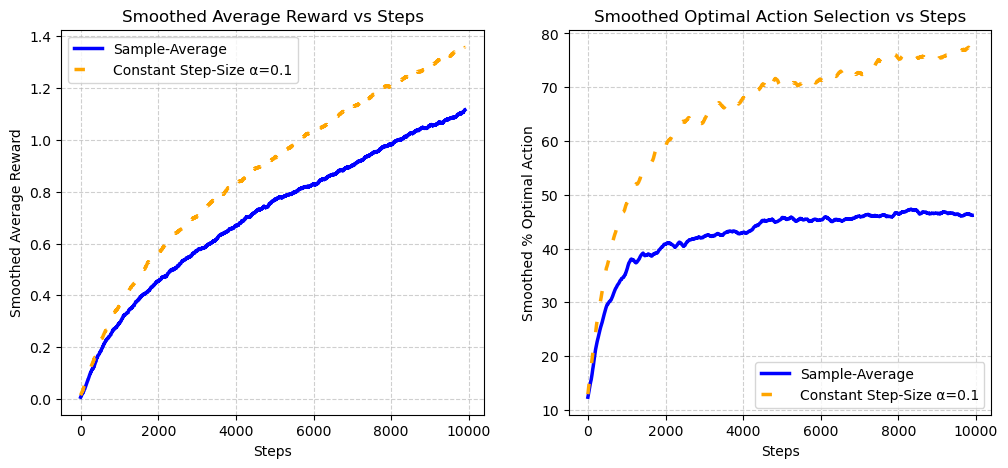

In [7]:

# 计算滑动平均（Moving Average）
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# x 轴对齐
x_smooth = np.arange(len(moving_average(rewards_sample_avg)))

plt.figure(figsize=(12, 5))

# 📌 平均奖励曲线（平滑版）
plt.subplot(1, 2, 1)
plt.plot(x_smooth, moving_average(rewards_sample_avg), linestyle="-", linewidth=2.5, color="blue", label='Sample-Average')
plt.plot(x_smooth, moving_average(rewards_const_alpha), linestyle=":", linewidth=2.5, color="orange", label='Constant Step-Size α=0.1')
plt.gca().lines[-1].set_dashes((3, 6))  # 设置点状虚线（间隔较大）
plt.xlabel("Steps")
plt.ylabel("Smoothed Average Reward")
plt.legend()
plt.title("Smoothed Average Reward vs Steps")
plt.grid(True, linestyle="--", alpha=0.6)  # 加网格线

# 📌 最优动作选择率曲线（平滑版）
plt.subplot(1, 2, 2)
plt.plot(x_smooth, moving_average(optimal_sample_avg), linestyle="-", linewidth=2.5, color="blue", label='Sample-Average')
plt.plot(x_smooth, moving_average(optimal_const_alpha), linestyle=":", linewidth=2.5, color="orange", label='Constant Step-Size α=0.1')
plt.gca().lines[-1].set_dashes((3, 6))  # 设置点状虚线（间隔较大）
plt.xlabel("Steps")
plt.ylabel("Smoothed % Optimal Action")
plt.legend()
plt.title("Smoothed Optimal Action Selection vs Steps")
plt.grid(True, linestyle="--", alpha=0.6)  # 加网格线

plt.show()
